# 03 — Discordant Gene Characterization

Characterize genes where FBA predictions and growth measurements disagree:
- **FBA-essential + growth-normal**: FBA over-predicts importance
- **FBA-blocked + growth-defect**: FBA under-predicts importance

Analyses:
1. COG category enrichment (Fisher's exact test)
2. Pangenome status (core vs accessory)
3. Functional annotation and pathway clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 150

DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')

triple = pd.read_csv(DATA_DIR / 'triple_gene_table.csv')
print(f'Loaded {len(triple)} genes')

Loaded 478 genes


## 1. Define Discordance Classes

In [2]:
# Define concordance/discordance classes
# Concordant: FBA-essential + growth-defect, FBA-blocked + growth-normal
# Discordant: FBA-essential + growth-normal (over-predict), FBA-blocked + growth-defect (under-predict)
# Variable: FBA-variable (ambiguous, not clearly concordant/discordant)

def classify_discord(row):
    fba = row['minimal_media_class']
    growth = row['any_growth_defect']
    if fba == 'essential' and growth:
        return 'concordant_essential'
    elif fba == 'essential' and not growth:
        return 'discordant_over'
    elif fba == 'blocked' and not growth:
        return 'concordant_blocked'
    elif fba == 'blocked' and growth:
        return 'discordant_under'
    elif fba == 'variable' and growth:
        return 'variable_defect'
    elif fba == 'variable' and not growth:
        return 'variable_normal'
    return 'other'

triple['discord_class'] = triple.apply(classify_discord, axis=1)

print('Discordance classes:')
class_counts = triple['discord_class'].value_counts()
for cls, n in class_counts.items():
    print(f'  {cls:<25} {n:>4} ({n/len(triple)*100:5.1f}%)')

# For enrichment analysis, compare discordant vs concordant+variable
triple['is_discordant'] = triple['discord_class'].isin(['discordant_over', 'discordant_under'])
print(f'\nTotal discordant: {triple["is_discordant"].sum()}')

Discordance classes:
  variable_defect            150 ( 31.4%)
  discordant_under           136 ( 28.5%)
  concordant_blocked          60 ( 12.6%)
  concordant_essential        57 ( 11.9%)
  variable_normal             54 ( 11.3%)
  discordant_over             21 (  4.4%)

Total discordant: 157


## 2. COG Category Enrichment

Test whether discordant genes are enriched in specific COG functional categories.

In [3]:
# COG category descriptions
COG_DESCRIPTIONS = {
    'A': 'RNA processing and modification',
    'B': 'Chromatin structure and dynamics',
    'C': 'Energy production and conversion',
    'D': 'Cell cycle control, cell division',
    'E': 'Amino acid transport and metabolism',
    'F': 'Nucleotide transport and metabolism',
    'G': 'Carbohydrate transport and metabolism',
    'H': 'Coenzyme transport and metabolism',
    'I': 'Lipid transport and metabolism',
    'J': 'Translation, ribosomal structure',
    'K': 'Transcription',
    'L': 'Replication, recombination, repair',
    'M': 'Cell wall/membrane biogenesis',
    'N': 'Cell motility',
    'O': 'Post-translational modification',
    'P': 'Inorganic ion transport',
    'Q': 'Secondary metabolite biosynthesis',
    'R': 'General function prediction only',
    'S': 'Function unknown',
    'T': 'Signal transduction',
    'U': 'Intracellular trafficking',
    'V': 'Defense mechanisms',
    'W': 'Extracellular structures',
    'X': 'Mobilome: prophages, transposons',
    'Y': 'Nuclear structure',
    'Z': 'Cytoskeleton',
}

# Expand composite COG categories (e.g., 'EH' -> ['E', 'H'])
def expand_cog(cog_str):
    if pd.isna(cog_str) or cog_str == '':
        return []
    return list(str(cog_str))

# Count COG categories
triple['cog_list'] = triple['cog'].apply(expand_cog)
cog_with_data = triple[triple['cog_list'].apply(len) > 0]
print(f'Genes with COG annotation: {len(cog_with_data)}/{len(triple)} ({len(cog_with_data)/len(triple)*100:.0f}%)')

# Count per COG category
all_cogs = Counter()
for cogs in triple['cog_list']:
    all_cogs.update(cogs)

print(f'\nCOG categories represented: {len(all_cogs)}')
cog_counts = pd.Series(all_cogs).sort_values(ascending=False)
print(cog_counts.head(10))

Genes with COG annotation: 62/478 (13%)

COG categories represented: 13
C    62
O    62
G    62
0    61
1    30
3    24
8    22
5    22
4    22
6    18
dtype: int64


In [4]:
# Fisher's exact test for each COG category:
# Compare discordant vs non-discordant genes
enrichment_results = []

for cog_cat in sorted(all_cogs.keys()):
    # Gene has this COG category?
    triple[f'has_cog_{cog_cat}'] = triple['cog_list'].apply(lambda x: cog_cat in x)

    # 2x2 table: discordant x has_cog
    a = (triple['is_discordant'] & triple[f'has_cog_{cog_cat}']).sum()  # discordant + has COG
    b = (triple['is_discordant'] & ~triple[f'has_cog_{cog_cat}']).sum()  # discordant + no COG
    c = (~triple['is_discordant'] & triple[f'has_cog_{cog_cat}']).sum()  # concordant + has COG
    d = (~triple['is_discordant'] & ~triple[f'has_cog_{cog_cat}']).sum()  # concordant + no COG

    if a + c >= 3:  # minimum 3 genes with this COG
        odds, p = stats.fisher_exact([[a, b], [c, d]])
        desc = COG_DESCRIPTIONS.get(cog_cat, 'Unknown')
        enrichment_results.append({
            'cog': cog_cat,
            'description': desc,
            'discordant': a,
            'concordant': c,
            'total': a + c,
            'odds_ratio': odds,
            'p_value': p,
            'disc_rate': a / (a + b) if (a + b) > 0 else 0,
            'bg_rate': c / (c + d) if (c + d) > 0 else 0,
        })

    # Clean up temp column
    triple.drop(columns=[f'has_cog_{cog_cat}'], inplace=True)

enrich_df = pd.DataFrame(enrichment_results).sort_values('p_value')

# Apply Benjamini-Hochberg FDR correction
from statsmodels.stats.multitest import multipletests
reject, pvals_corr, _, _ = multipletests(enrich_df['p_value'], method='fdr_bh')
enrich_df['q_value'] = pvals_corr
enrich_df['significant'] = reject

print('COG enrichment in discordant genes (Fisher exact, BH-FDR):')
display(enrich_df[['cog', 'description', 'discordant', 'concordant', 'total',
                    'odds_ratio', 'p_value', 'q_value', 'significant']].round(4).head(15))

COG enrichment in discordant genes (Fisher exact, BH-FDR):


,cog,description,discordant,concordant,total,odds_ratio,p_value,q_value,significant
1,1,Unknown,2,24,26,0.1597,0.0043,0.0557,False
5,5,Unknown,3,18,21,0.3279,0.0936,0.2975,False
0,0,Unknown,11,38,49,0.5611,0.1106,0.2975,False
11,G,Carbohydrate transport and metabolism,15,47,62,0.6158,0.1470,0.2975,False
10,C,Energy production and conversion,15,47,62,0.6158,0.1470,0.2975,False
12,O,Post-translational modification,15,47,62,0.6158,0.1470,0.2975,False
9,9,Unknown,2,13,15,0.3057,0.1602,0.2975,False
6,6,Unknown,3,14,17,0.4272,0.2007,0.3261,False
7,7,Unknown,3,11,14,0.5490,0.5643,0.8151,False
3,3,Unknown,9,15,24,1.2405,0.6577,0.8551,False


In [5]:
# Enrichment by discordance direction
for disc_type, label in [('discordant_over', 'FBA over-predicts (essential+normal)'),
                          ('discordant_under', 'FBA under-predicts (blocked+defect)')]:
    disc_mask = triple['discord_class'] == disc_type
    results = []
    for cog_cat in sorted(all_cogs.keys()):
        has_cog = triple['cog_list'].apply(lambda x: cog_cat in x)
        a = (disc_mask & has_cog).sum()
        b = (disc_mask & ~has_cog).sum()
        c = (~disc_mask & has_cog).sum()
        d = (~disc_mask & ~has_cog).sum()
        if a + c >= 3:
            odds, p = stats.fisher_exact([[a, b], [c, d]])
            results.append({
                'cog': cog_cat,
                'description': COG_DESCRIPTIONS.get(cog_cat, 'Unknown'),
                'in_class': a,
                'odds_ratio': odds,
                'p_value': p
            })
    rdf = pd.DataFrame(results).sort_values('p_value')
    if len(rdf) > 0:
        reject_dir, pvals_dir, _, _ = multipletests(rdf['p_value'], method='fdr_bh')
        rdf['q_value'] = pvals_dir
    print(f'\n{label} (n={disc_mask.sum()}):')
    display(rdf.head(8).round(4))


FBA over-predicts (essential+normal) (n=21):


,cog,description,in_class,odds_ratio,p_value,q_value
10,C,Energy production and conversion,1,0.3246,0.5009,1.0
12,O,Post-translational modification,1,0.3246,0.5009,1.0
11,G,Carbohydrate transport and metabolism,1,0.3246,0.5009,1.0
4,4,Unknown,0,0.0000,0.6152,1.0
1,1,Unknown,0,0.0000,0.6195,1.0
0,0,Unknown,1,0.4260,0.7114,1.0
3,3,Unknown,1,0.9435,1.0000,1.0
2,2,Unknown,0,0.0000,1.0000,1.0



FBA under-predicts (blocked+defect) (n=136):


,cog,description,in_class,odds_ratio,p_value,q_value
1,1,Unknown,2,0.1978,0.0134,0.1747
5,5,Unknown,2,0.2537,0.0503,0.3268
0,0,Unknown,10,0.6166,0.2418,0.5481
9,9,Unknown,2,0.3777,0.2515,0.5481
12,O,Post-translational modification,14,0.7029,0.2951,0.5481
11,G,Carbohydrate transport and metabolism,14,0.7029,0.2951,0.5481
10,C,Energy production and conversion,14,0.7029,0.2951,0.5481
6,6,Unknown,3,0.5285,0.4178,0.6790


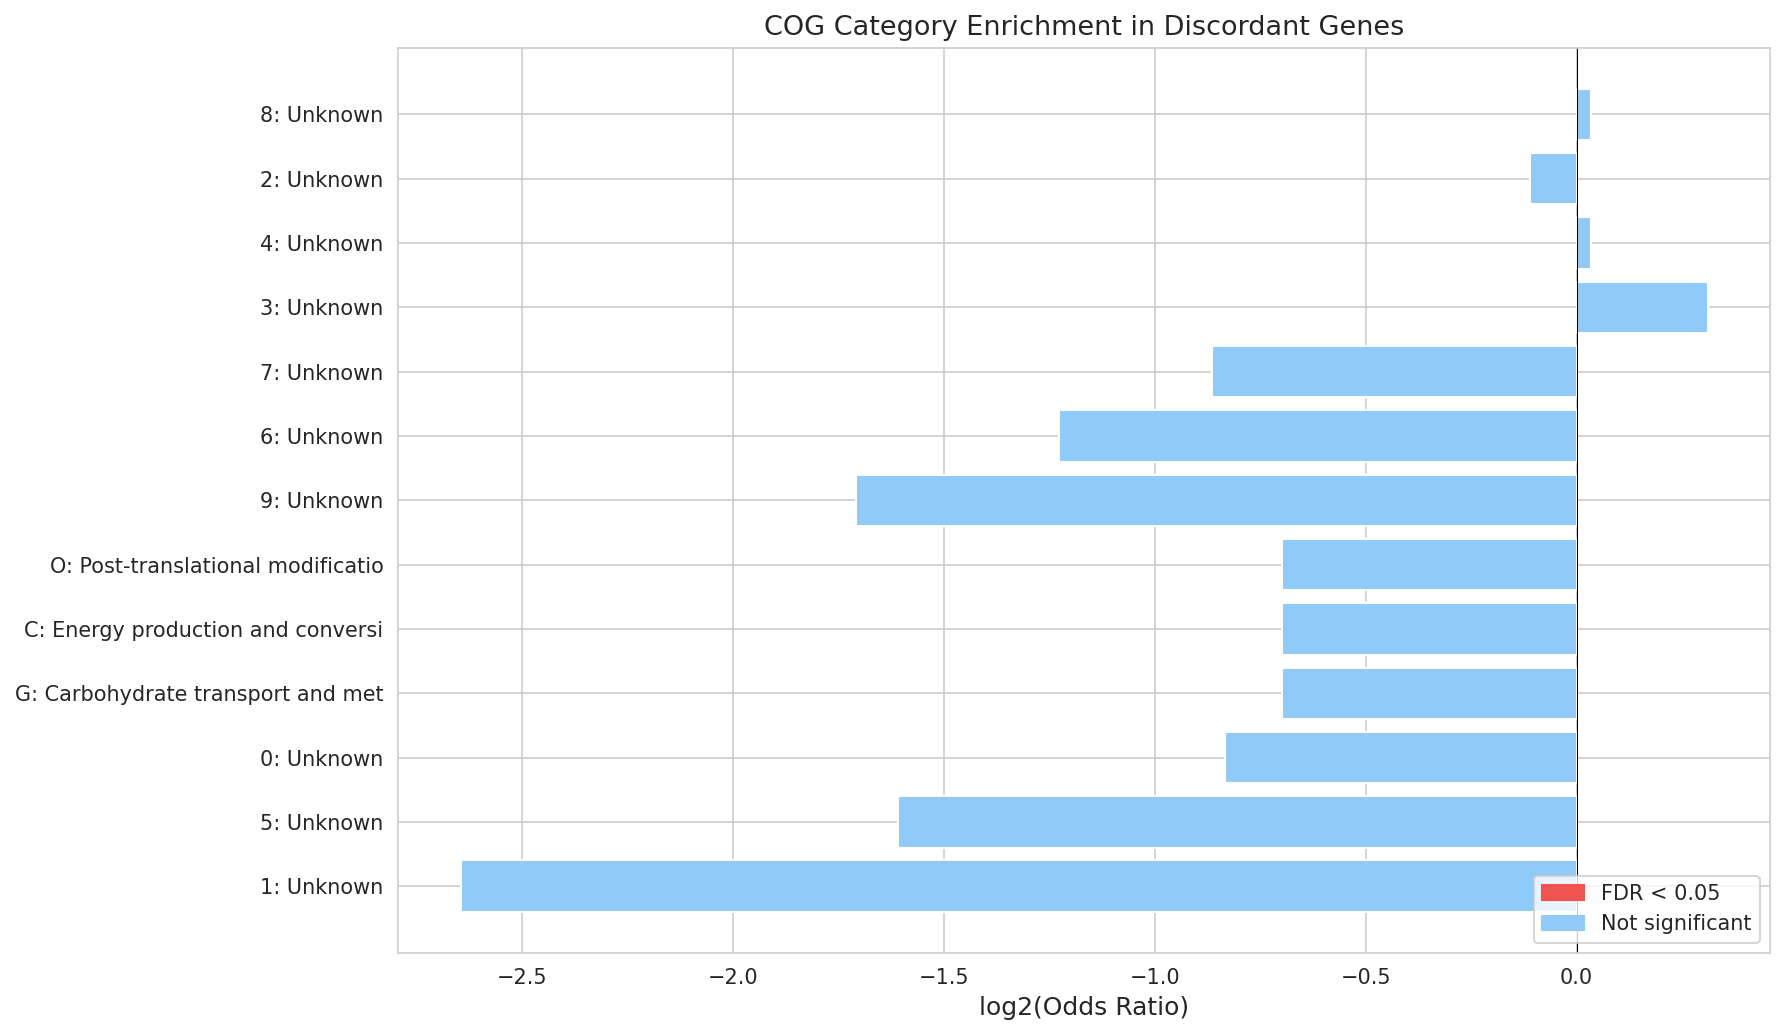

In [6]:
# Visualization: COG enrichment
fig, ax = plt.subplots(figsize=(12, 7))

# Plot log2(odds ratio) for top COGs by significance
plot_df = enrich_df.head(15).copy()
plot_df['log2_or'] = np.log2(plot_df['odds_ratio'].clip(lower=0.01))
plot_df['label'] = plot_df.apply(
    lambda r: f"{r['cog']}: {r['description'][:30]}" if pd.notna(r['description']) else r['cog'],
    axis=1
)

colors = ['#EF5350' if q < 0.05 else '#90CAF9' for q in plot_df['q_value']]
bars = ax.barh(plot_df['label'], plot_df['log2_or'], color=colors)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('log2(Odds Ratio)', fontsize=12)
ax.set_title('COG Category Enrichment in Discordant Genes', fontsize=13)

# Add significance markers
for i, (_, row) in enumerate(plot_df.iterrows()):
    if row['q_value'] < 0.05:
        ax.text(row['log2_or'] + 0.05, i, '*', fontsize=14, va='center', color='red')

ax.legend(handles=[
    plt.Rectangle((0,0),1,1, color='#EF5350', label='FDR < 0.05'),
    plt.Rectangle((0,0),1,1, color='#90CAF9', label='Not significant')
], loc='lower right')

plt.tight_layout()
plt.savefig(FIG_DIR / 'cog_enrichment_discordant.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Pangenome Status of Discordant Genes

Are discordant genes more likely to be core or accessory?

In [7]:
# Pangenome status by discordance class
pan_data = triple[triple['pangenome_is_core'].notna()].copy()
pan_data['core'] = pan_data['pangenome_is_core'].astype(bool)

print('Pangenome status by discordance class:')
for cls in ['concordant_essential', 'discordant_over', 'variable_defect',
            'variable_normal', 'discordant_under', 'concordant_blocked']:
    mask = pan_data['discord_class'] == cls
    n_total = mask.sum()
    n_core = (mask & pan_data['core']).sum()
    if n_total > 0:
        print(f'  {cls:<25} {n_core:>3}/{n_total:>3} core ({n_core/n_total*100:5.1f}%)')

# Fisher's exact: discordant vs concordant, core vs accessory
disc_core = (pan_data['is_discordant'] & pan_data['core']).sum()
disc_acc = (pan_data['is_discordant'] & ~pan_data['core']).sum()
conc_core = (~pan_data['is_discordant'] & pan_data['core']).sum()
conc_acc = (~pan_data['is_discordant'] & ~pan_data['core']).sum()
odds_pan, p_pan = stats.fisher_exact([[disc_core, disc_acc], [conc_core, conc_acc]])
print(f'\nFisher exact (discordant core enrichment): OR={odds_pan:.2f}, p={p_pan:.4f}')

Pangenome status by discordance class:
  concordant_essential       56/ 57 core ( 98.2%)
  discordant_over            21/ 21 core (100.0%)
  variable_defect           146/150 core ( 97.3%)
  variable_normal            52/ 54 core ( 96.3%)
  discordant_under          129/135 core ( 95.6%)
  concordant_blocked         56/ 60 core ( 93.3%)

Fisher exact (discordant core enrichment): OR=0.89, p=0.7971


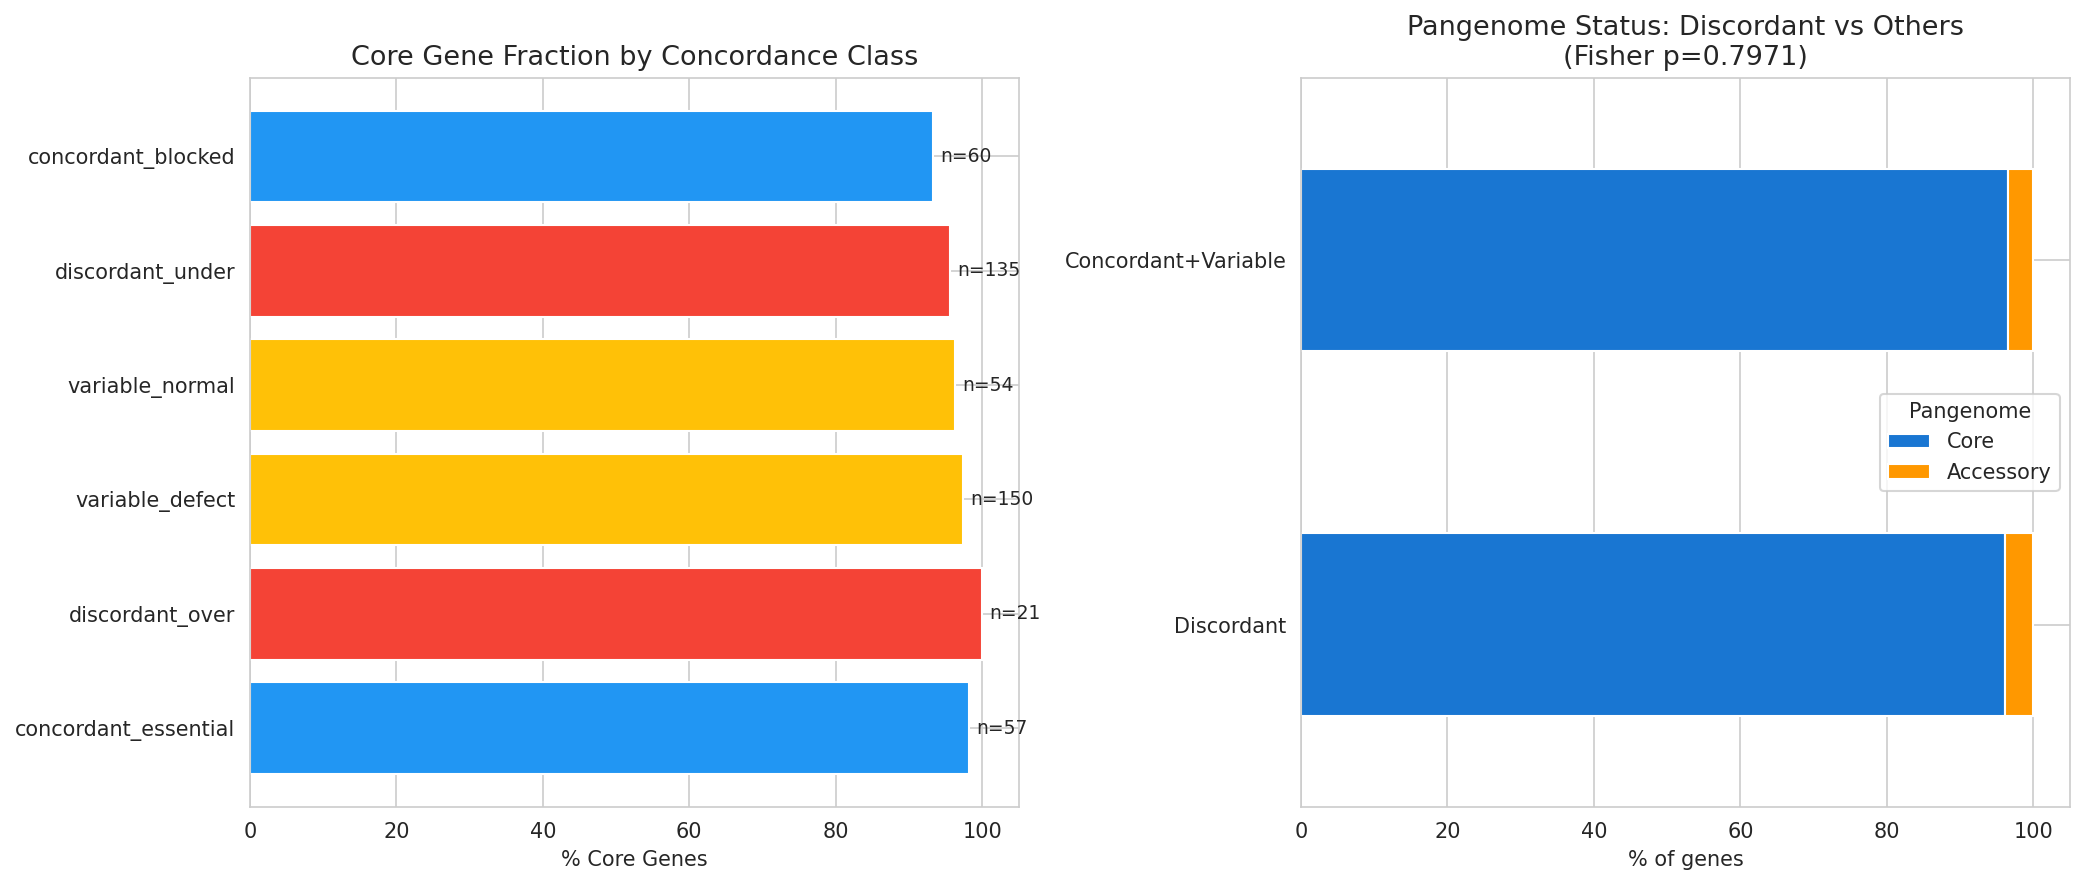

In [8]:
# Visualization: pangenome status by discordance class
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Core fraction by class
class_order = ['concordant_essential', 'discordant_over', 'variable_defect',
               'variable_normal', 'discordant_under', 'concordant_blocked']
core_rates = []
for cls in class_order:
    mask = pan_data['discord_class'] == cls
    n = mask.sum()
    if n > 0:
        core_rates.append({
            'class': cls,
            'core_pct': (mask & pan_data['core']).sum() / n * 100,
            'n': n
        })

core_df = pd.DataFrame(core_rates)
colors_bar = ['#2196F3' if 'concordant' in c else '#F44336' if 'discordant' in c else '#FFC107'
              for c in core_df['class']]
bars = axes[0].barh(core_df['class'], core_df['core_pct'], color=colors_bar)
axes[0].set_xlabel('% Core Genes')
axes[0].set_title('Core Gene Fraction by Concordance Class', fontsize=13)
for i, (_, row) in enumerate(core_df.iterrows()):
    axes[0].text(row['core_pct'] + 1, i, f'n={row["n"]:.0f}', va='center', fontsize=9)

# Panel 2: Stacked bar: discordant vs concordant
summary = pd.DataFrame({
    'Discordant': [disc_core, disc_acc],
    'Concordant+Variable': [conc_core, conc_acc]
}, index=['Core', 'Accessory'])
summary_pct = summary.div(summary.sum()) * 100
summary_pct.T.plot(kind='barh', stacked=True, ax=axes[1],
                    color=['#1976D2', '#FF9800'])
axes[1].set_xlabel('% of genes')
axes[1].set_title(f'Pangenome Status: Discordant vs Others\n(Fisher p={p_pan:.4f})', fontsize=13)
axes[1].legend(title='Pangenome')

plt.tight_layout()
plt.savefig(FIG_DIR / 'pangenome_discordance.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Functional Annotation of Discordant Genes

Examine RAST function and KEGG annotations for discordant genes.

In [9]:
# Top RAST functions in discordant genes
for disc_type, label in [('discordant_over', 'FBA over-predicts'),
                          ('discordant_under', 'FBA under-predicts')]:
    disc = triple[triple['discord_class'] == disc_type]
    funcs = disc['rast_function'].dropna().value_counts().head(15)
    print(f'\nTop RAST functions — {label} (n={len(disc)}):')
    for func, count in funcs.items():
        print(f'  {count:>3}  {func[:80]}')


Top RAST functions — FBA over-predicts (n=21):
    2  Multimodular transpeptidase-transglycosylase (EC 2.4.1.129) (EC 3.4.-.-)
    2  Cardiolipin synthase (EC 2.7.8.-) phosphatidylethanolamine-utilizing, bacterial 
    2  Undecaprenyl-diphosphatase (EC 3.6.1.27)
    1  (2E,6E)-farnesyl diphosphate synthase (EC 2.5.1.10)
    1  Phosphoribosylglycinamide formyltransferase (EC 2.1.2.2)
    1  Cytosine/purine/uracil/thiamine/allantoin permease family protein
    1  N-succinyl-L,L-diaminopimelate aminotransferase (EC 2.6.1.17), type 2
    1  Lysophospholipase (EC 3.1.1.5)
    1  2-keto-3-deoxy-D-arabino-heptulosonate-7-phosphate synthase I alpha (EC 2.5.1.54
    1  Nucleoside:H+ symporter:Major facilitator superfamily
    1  4-hydroxybenzoate transporter
    1  Phosphatidate cytidylyltransferase (EC 2.7.7.41)
    1  Serine acetyltransferase (EC 2.3.1.30)
    1  Phosphoserine phosphatase (EC 3.1.3.3)
    1  Isocitrate dehydrogenase [NADP] (EC 1.1.1.42)

Top RAST functions — FBA under-predic

In [10]:
# KEGG ortholog analysis
ko_data = triple[triple['ko'].notna()].copy()
print(f'Genes with KO annotation: {len(ko_data)}/{len(triple)}')

# Count KOs per discordance class
for cls in ['discordant_over', 'discordant_under', 'concordant_essential', 'concordant_blocked']:
    subset = ko_data[ko_data['discord_class'] == cls]
    n_ko = len(subset)
    n_unique = subset['ko'].nunique()
    print(f'  {cls:<25}: {n_ko} genes, {n_unique} unique KOs')

Genes with KO annotation: 407/478
  discordant_over          : 17 genes, 15 unique KOs
  discordant_under         : 119 genes, 109 unique KOs
  concordant_essential     : 51 genes, 46 unique KOs
  concordant_blocked       : 47 genes, 42 unique KOs


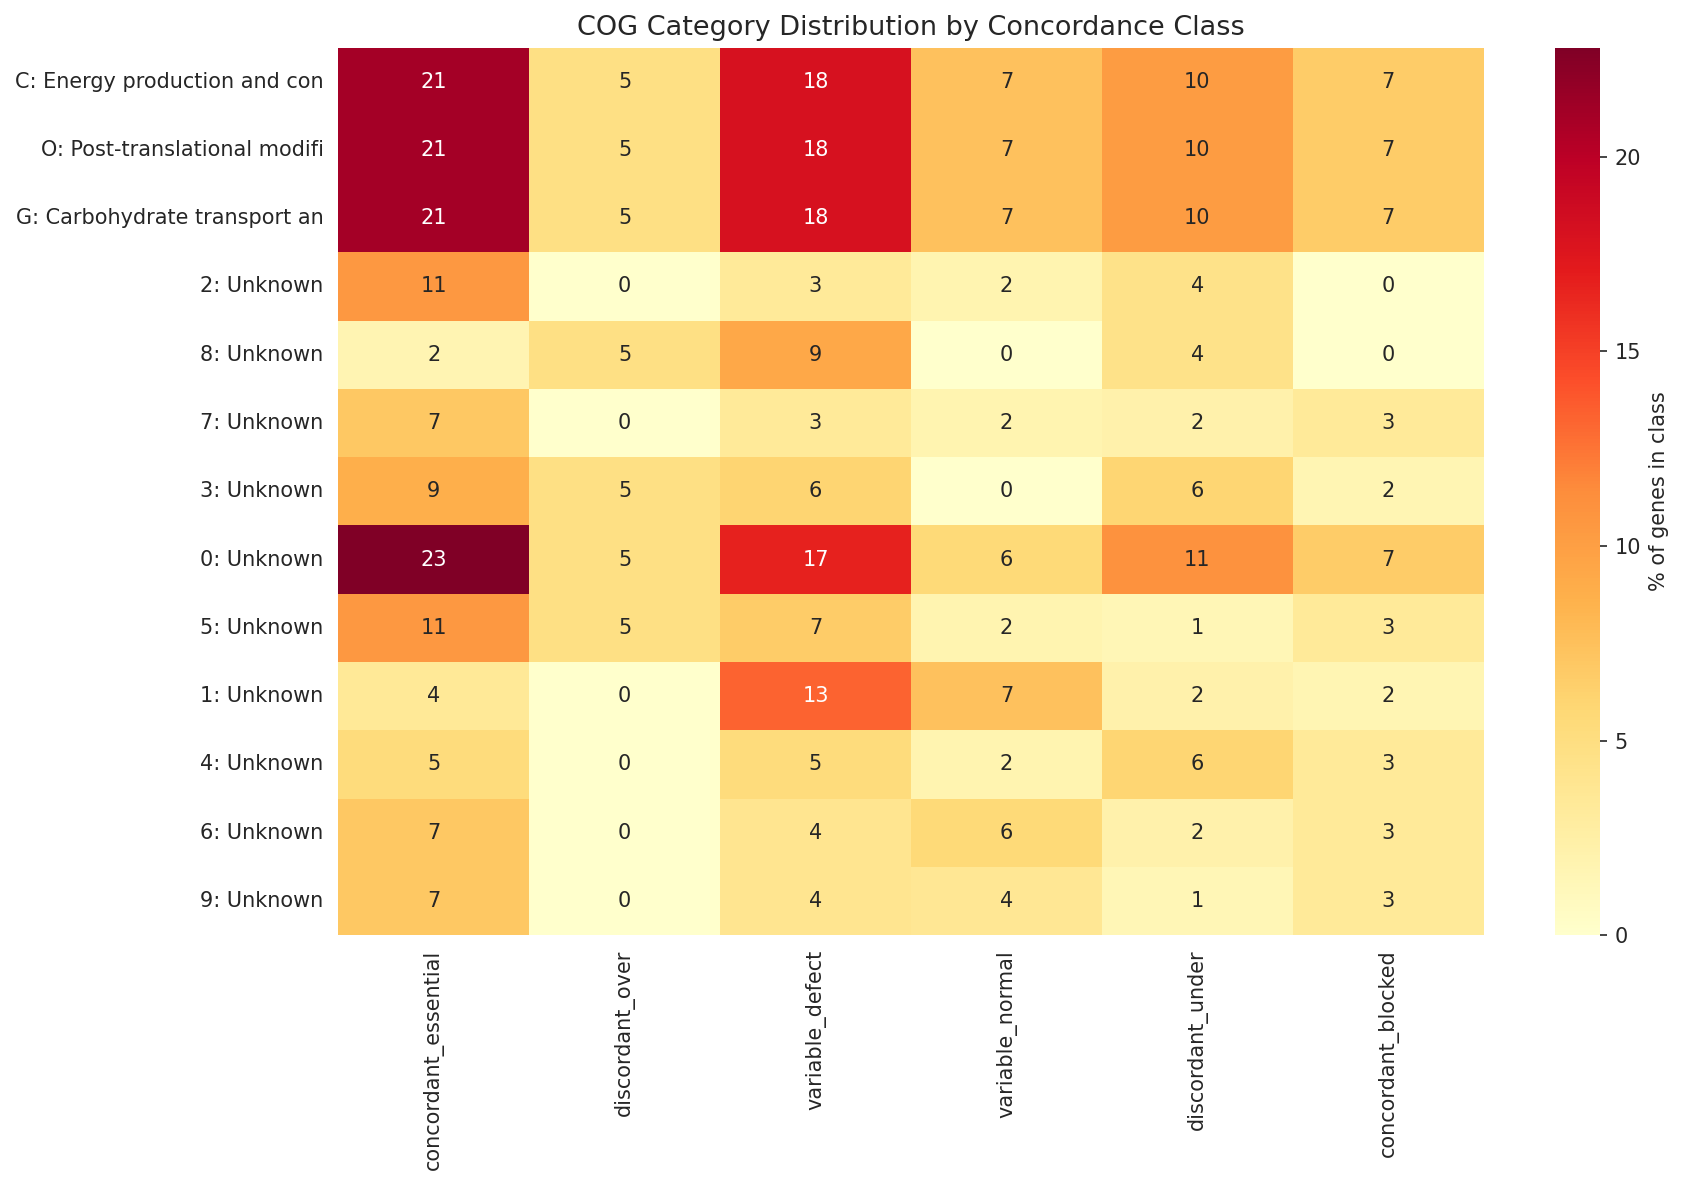

In [11]:
# Heatmap: discordance class composition by COG category
# Build a matrix of COG counts per discordance class
cog_class_matrix = pd.DataFrame()
for cls in class_order:
    cls_genes = triple[triple['discord_class'] == cls]
    cog_counter = Counter()
    for cogs in cls_genes['cog_list']:
        cog_counter.update(cogs)
    n_genes = len(cls_genes)
    # Normalize to fraction of genes in class
    cog_fracs = {cog: count/n_genes*100 for cog, count in cog_counter.items()}
    cog_class_matrix[cls] = pd.Series(cog_fracs)

cog_class_matrix = cog_class_matrix.fillna(0)
# Only show COGs with >5% in at least one class
keep_cogs = cog_class_matrix.index[cog_class_matrix.max(axis=1) > 5]
plot_matrix = cog_class_matrix.loc[keep_cogs]

# Add descriptions as labels
labels = [f"{c}: {COG_DESCRIPTIONS.get(c, 'Unknown')[:25]}" for c in plot_matrix.index]

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(plot_matrix.values, annot=True, fmt='.0f', cmap='YlOrRd',
            xticklabels=plot_matrix.columns, yticklabels=labels,
            ax=ax, cbar_kws={'label': '% of genes in class'})
ax.set_title('COG Category Distribution by Concordance Class', fontsize=13)
plt.tight_layout()
plt.savefig(FIG_DIR / 'cog_by_discordance_class.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Summary

In [12]:
print('='*60)
print('DISCORDANT GENE CHARACTERIZATION SUMMARY')
print('='*60)

n_disc = triple['is_discordant'].sum()
n_over = (triple['discord_class'] == 'discordant_over').sum()
n_under = (triple['discord_class'] == 'discordant_under').sum()

print(f'\nTotal discordant genes: {n_disc}/{len(triple)} ({n_disc/len(triple)*100:.1f}%)')
print(f'  FBA over-predicts (essential+normal): {n_over}')
print(f'  FBA under-predicts (blocked+defect): {n_under}')

print(f'\nCOG enrichment:')
sig_cogs = enrich_df[enrich_df['q_value'] < 0.05]
if len(sig_cogs) > 0:
    for _, row in sig_cogs.iterrows():
        direction = 'enriched' if row['odds_ratio'] > 1 else 'depleted'
        print(f'  {row["cog"]} ({row["description"][:30]}): '
              f'{direction} (OR={row["odds_ratio"]:.2f}, q={row["q_value"]:.3f})')
else:
    print('  No COG categories significantly enriched (FDR < 0.05)')

print(f'\nPangenome:')
print(f'  Discordant core enrichment: OR={odds_pan:.2f}, p={p_pan:.4f}')

print(f'\nAnnotation coverage:')
print(f'  COG: {triple["cog"].notna().sum()}/{len(triple)}')
print(f'  KO: {triple["ko"].notna().sum()}/{len(triple)}')
print(f'  RAST: {triple["rast_function"].notna().sum()}/{len(triple)}')

DISCORDANT GENE CHARACTERIZATION SUMMARY

Total discordant genes: 157/478 (32.8%)
  FBA over-predicts (essential+normal): 21
  FBA under-predicts (blocked+defect): 136

COG enrichment:
  No COG categories significantly enriched (FDR < 0.05)

Pangenome:
  Discordant core enrichment: OR=0.89, p=0.7971

Annotation coverage:
  COG: 62/478
  KO: 407/478
  RAST: 478/478
